In [1]:
from collections import defaultdict
from collections import namedtuple
import pandas as pd
import json
import time
import copy
import matplotlib.pyplot as plt
import matplotlib

In [2]:
%matplotlib inline

In [3]:
t0 = time.time()

In [4]:
feat = pd.read_table("/outs/features.txt", sep=' ')
# feat = pd.read_table("test/test_feat.txt", sep=' ')
feat.head()

,chr,start,end,strand,type
0,1.0,335,649,+,gene
1,1.0,538,792,+,gene
2,1.0,1807,2169,-,gene
3,1.0,2480,2707,+,gene
4,1.0,7013,9049,-,gene


In [34]:
set(feat["type"])

{'CUTs',
 'LTR_retrotransposon',
 'ORFs',
 'SUTs',
 'XUTs',
 'gene',
 'ncRNA_gene',
 'other',
 'snRNA_gene',
 'snoRNA_gene',
 'telomerase_RNA_gene',
 'transposable_element_gene'}

In [10]:
feat.shape

(15799, 5)

Defining a namedtuple here that will be used for the features. Adding an antisense boolean attribute to differentiate between sense and antisense promotion.

In [5]:
Feat = namedtuple('Feat', ['chr', 'start', 'end', 'strand', 'type'], defaults = (False,))

Create a dictionary containing every position of each feature. Key is (chromosome, position, strand) and value is a list of namedtuples Feat.

In [6]:
pos = defaultdict(list)
for row in feat.itertuples(index=False):
    for i in range(row.start, row.end+1):
        item = Feat(row.chr, row.start, row.end, row.strand, row.type)
        pos[(row.chr, i, row.strand)].append(item)

In [11]:
pd.Series({key:len(pos[key])>1 for key in pos}).value_counts()

True     10466123
False     3121510
Name: count, dtype: int64

In [13]:
1-10466123/(10466123+3121510)

0.22973169793443793

In [15]:
[(key, pos[key]) for key in pos if len(pos[key]) > 2][:5]

[((1.0, 35096, '+'),
  [Feat(chr=1.0, start=33345, end=35113, strand='+', type='gene'),
   Feat(chr=1.0, start=34983, end=36433, strand='+', type='gene'),
   Feat(chr=1.0, start=35096, end=36392, strand='+', type='ORFs')]),
 ((1.0, 35097, '+'),
  [Feat(chr=1.0, start=33345, end=35113, strand='+', type='gene'),
   Feat(chr=1.0, start=34983, end=36433, strand='+', type='gene'),
   Feat(chr=1.0, start=35096, end=36392, strand='+', type='ORFs')]),
 ((1.0, 35098, '+'),
  [Feat(chr=1.0, start=33345, end=35113, strand='+', type='gene'),
   Feat(chr=1.0, start=34983, end=36433, strand='+', type='gene'),
   Feat(chr=1.0, start=35096, end=36392, strand='+', type='ORFs')]),
 ((1.0, 35099, '+'),
  [Feat(chr=1.0, start=33345, end=35113, strand='+', type='gene'),
   Feat(chr=1.0, start=34983, end=36433, strand='+', type='gene'),
   Feat(chr=1.0, start=35096, end=36392, strand='+', type='ORFs')]),
 ((1.0, 35100, '+'),
  [Feat(chr=1.0, start=33345, end=35113, strand='+', type='gene'),
   Feat(chr=1.0,

In [7]:
# sorted_pos = sorted(pos.items(), key = lambda i: i[0])

In [16]:
net = pd.read_table("/outs/net.txt", sep=' ')
# net = pd.read_table("test/net.txt", sep=' ')
net.head()

,pos,value,chr,reads,strand
0,156,0.481988,1,1,+
1,5793,0.481988,1,1,+
2,5871,0.481988,1,1,+
3,5883,0.481988,1,1,+
4,5889,0.481988,1,1,+


First step is counting reads for each feature. If there is an overlap, I do a weighted split where the weight is the inverse of distance from the start site.

In [17]:
d = defaultdict(float)
ua = defaultdict(float)
ua_dist = defaultdict(float)
for n in net.itertuples():
    # making the key
    tup = (n.chr, n.pos, n.strand)
    # check if the position is part of a feature
    if tup in pos:
        keys = pos.get(tup)
        total = 0 # this is the denominator
        checksum = 0
        # on the + strand, check distance from start
        if n.strand == "+":
            # first find the denominator
            for key in keys:
                total += 1/(tup[1]-key.start + 1)                
            # populate d with the weighted reads    
            for key in keys:
                d[key] += n.reads * (1/(tup[1]-key.start + 1)) / total
                checksum += n.reads * (1/(tup[1]-key.start + 1)) / total
        # on the - strand, check distance from end    
        else:
            # first find the denominator
            for key in keys:
                total += 1/(key.end - tup[1] + 1)
            # populate d with the weighted reads    
            for key in keys:
                d[key] += n.reads * (1/(key.end - tup[1] + 1)) / total
                checksum += n.reads * (1/(key.end - tup[1] + 1)) / total
        # check that we assigned all reads somewhere
        if n.reads != round(checksum):
            print(n, "failed checksum")
    # when position is not a part of any feature
    else:
        # find nearest feature
        min_dist = None
        near_feat = None
        window_size = 600
        keys = None
        upper = None
        lower = None
        flag = False
        flagged_keys = []
        key2 = None
        # checker
        opp = (n.chr, n.pos, '+' if n.strand == "-" else "-")
        if opp in pos:
            flag = True
            flagged_keys = pos.get(opp)
            # for key in keys:
            #     lower = min(lower, key.start) if lower is not None else key.start
            #     upper = max(upper, key.end) if upper is not None else key.end
        
        for i in range(0, window_size):             
            t_same = (n.chr, (n.pos-i) if n.strand == '+' else (n.pos+i), n.strand)
            t_opp = (n.chr, (n.pos-i) if n.strand == '+' else (n.pos+i), '+' if n.strand == "-" else "-")
            if t_same in pos:
                keys = pos.get(t_same)
                for key in keys:
                    key2 = Feat(key.chr, key.start, key.end, key.strand, key.type+'_same')
                    ua[key2] += n.reads/len(keys)
                    ua_dist[key2] = max(ua_dist[key2], min(abs(n.pos-key.start), abs(n.pos-key.end))) if ua_dist[key2] != 0 \
                    else min(abs(n.pos-key.start), abs(n.pos-key.end))
                if ua_dist[key2] > 1000:
                    print(n, key2, t_same)
                break

            # if flag:
            #     if t_opp[1] >= lower and t_opp[1] <= upper:
            #         continue
            
            if t_opp in pos:
                keys = pos.get(t_opp)
                for key in keys:
                    if key in flagged_keys:
                        continue
                    key2 = Feat(key.chr, key.start, key.end, key.strand, key.type+'_opp')
                    ua[key2] += n.reads/len(keys)
                    ua_dist[key2] = max(ua_dist[key2], min(abs(n.pos-key.start), abs(n.pos-key.end))) if ua_dist[key2] != 0 \
                    else min(abs(n.pos-key.start), abs(n.pos-key.end))
                if key2:
                    if ua_dist[key2] > 1000:
                        print(n, key2, t_opp)
                break



In [18]:
pos[(4, 155640, '-')]

[Feat(chr=4.0, start=149203, end=155640, strand='-', type='gene'),
 Feat(chr=4.0, start=149100, end=155932, strand='-', type='ORFs')]

In [19]:
len(ua), len(ua_dist)

(4862, 4862)

In [20]:
list(ua.keys())[:5]

[Feat(chr=1.0, start=5075, end=6237, strand='-', type='SUTs_opp'),
 Feat(chr=1.0, start=7276, end=9260, strand='-', type='ORFs_opp'),
 Feat(chr=1.0, start=9368, end=9600, strand='+', type='SUTs_same'),
 Feat(chr=1.0, start=9807, end=10460, strand='+', type='gene_same'),
 Feat(chr=1.0, start=10732, end=11140, strand='-', type='CUTs_opp')]

In [21]:
len(feat)

15799

In [22]:
sum(list(ua.values()))/len(ua), sum(list(ua_dist.values()))/len(ua_dist)

(81.65508021390374, 183.48992184286303)

In [35]:
min(list(ua_dist.values())), max(list(ua_dist.values()))

(1, 599)

In [24]:
len([item for item in list(ua_dist.keys()) if item.type.endswith('same')]), len([item for item in list(ua_dist.keys()) if item.type.endswith('opp')])

(2079, 2783)

<Axes: ylabel='Frequency'>

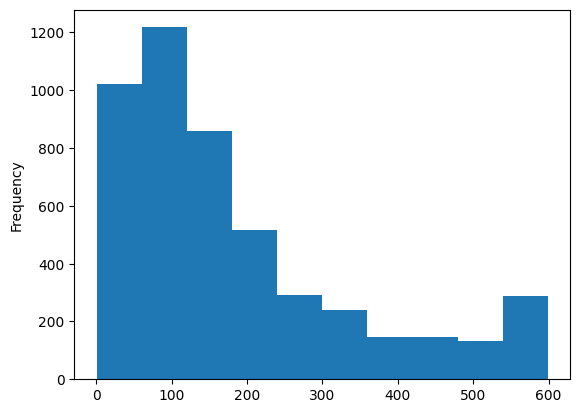

In [25]:
pd.Series(ua_dist).plot.hist()

In [26]:
pd.Series(ua_dist).mean() + 1.5*pd.Series(ua_dist).std()

np.float64(418.7515786506267)

In [27]:
# d

In [28]:
# ua, ua_dist

In [29]:
# ua[Feat(chr=1.0, start=335, end=649, strand='+', type='gene_right')], ua_dist[Feat(chr=1.0, start=335, end=649, strand='+', type='gene_right')]

In [30]:
for key in ua:
    if key.strand == '+' and key.type.endswith('same'):
        key2 = Feat(key.chr, key.start, key.end+ua_dist[key], key.strand, key.type)
    if key.strand == '+' and key.type.endswith('opp'):
        key2 = Feat(key.chr, key.start-ua_dist[key], key.start, '-', key.type)
    if key.strand == '-' and key.type.endswith('same'):
        key2 = Feat(key.chr, key.start-ua_dist[key], key.end, key.strand, key.type)
    if key.strand == '-' and key.type.endswith('opp'):
        key2 = Feat(key.chr, key.end, key.end+ua_dist[key], '+', key.type)
        
    d[key2] = ua[key]

In [31]:
df = pd.DataFrame([d])
df = df.transpose()
df = df.rename(columns={0: "reads"})
df = df.reset_index(names = "og_index")
df = pd.concat([pd.DataFrame(df["og_index"].tolist(), columns = ["chr", "start", "end", "strand", "type"]), df[["reads"]]], axis=1) 
df.head()

,chr,start,end,strand,type,reads
0,1.0,9368,9600,+,SUTs,74.000000
1,1.0,9807,10460,+,gene,48.000000
2,1.0,11270,11785,+,XUTs,184.683701
3,1.0,11313,15151,+,gene,251.659257
4,1.0,13123,13701,+,XUTs,27.105644


In [36]:
df["type"].value_counts()

type
gene                              6327
ORFs                              5170
XUTs                              1643
gene_opp                          1469
gene_same                         1222
CUTs                               924
SUTs                               832
ORFs_opp                           754
ORFs_same                          359
other                              329
XUTs_same                          266
XUTs_opp                           225
SUTs_opp                           117
CUTs_opp                           113
snoRNA_gene                         77
SUTs_same                           73
CUTs_same                           59
other_opp                           43
LTR_retrotransposon_same            36
LTR_retrotransposon_opp             34
LTR_retrotransposon                 33
transposable_element_gene           32
other_same                          31
ncRNA_gene                          28
snoRNA_gene_opp                     21
snoRNA_gene_same    

In [43]:
len(df[df["type"].str.endswith("opp") | df["type"].str.endswith("same")])

4862

In [50]:
df[df["type"].str.endswith("opp") | df["type"].str.endswith("same")]["reads"].sum()

np.float64(397007.0)

In [48]:
len(df[~df["type"].str.endswith("opp") & ~df["type"].str.endswith("same")])

15402

In [61]:
len(df[df["type"].str.endswith("same")])

2079

In [62]:
len(df[df["type"].str.endswith("opp")])

2783

In [51]:
df[~df["type"].str.endswith("opp") & ~df["type"].str.endswith("same")]["reads"].sum()

np.float64(19292307.0)

In [52]:
df["reads"].sum()

np.float64(19689313.999999996)

In [54]:
100*397007/19689313.999999996

2.0163577055046207

In [57]:
len(df[(df["type"] == "XUTs") | (df["type"] == "CUTs") | (df["type"] == "XUTs")])

2567

In [58]:
df[(df["type"] == "XUTs") | (df["type"] == "CUTs") | (df["type"] == "XUTs")]["reads"].sum()

np.float64(937647.785172915)

In [59]:
100*937647.785172915/19689313.999999996

4.762216627623061

In [23]:
df["length"] = df["end"] - df["start"]
df.head()

,chr,start,end,strand,type,reads,length
0,1.0,9368,9600,+,SUTs,74.000000,232
1,1.0,9807,10460,+,gene,48.000000,653
2,1.0,11270,11785,+,XUTs,184.683701,515
3,1.0,11313,15151,+,gene,251.659257,3838
4,1.0,13123,13701,+,XUTs,27.105644,578


<Axes: xlabel='length', ylabel='reads'>

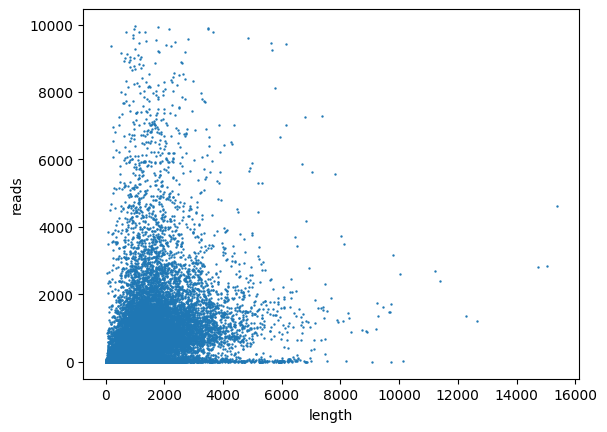

In [24]:
df[df["reads"] < 1e4].plot.scatter(y="reads", x="length", s=0.5)

In [25]:
list(set(df["type"]))

['XUTs_same',
 'gene',
 'other_same',
 'CUTs_opp',
 'ncRNA_gene_same',
 'ncRNA_gene',
 'CUTs',
 'SUTs_same',
 'snRNA_gene_same',
 'ncRNA_gene_opp',
 'gene_same',
 'snRNA_gene_opp',
 'snRNA_gene',
 'SUTs_opp',
 'XUTs',
 'LTR_retrotransposon',
 'telomerase_RNA_gene',
 'snoRNA_gene_same',
 'ORFs_same',
 'snoRNA_gene_opp',
 'other',
 'ORFs_opp',
 'snoRNA_gene',
 'LTR_retrotransposon_same',
 'transposable_element_gene_same',
 'XUTs_opp',
 'ORFs',
 'LTR_retrotransposon_opp',
 'SUTs',
 'gene_opp',
 'CUTs_same',
 'transposable_element_gene',
 'other_opp']

In [26]:
print(df[(df["reads"] < 1e5) & (df["type"].apply(lambda item: item in ["gene", "ORFs"]))].shape)
print(df[(df["reads"] < 1e5)].shape)

(11497, 7)
(20261, 7)


<Axes: xlabel='length', ylabel='reads'>

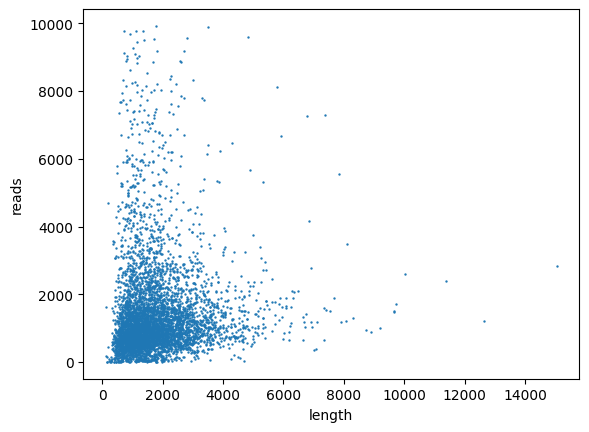

In [27]:
df[(df["reads"] < 1e4) & (df["type"].apply(lambda item: item in ["ORFs"]))].plot.scatter(y="reads", x="length", s=0.5)

In [28]:
# d

In [29]:
expand = defaultdict(int)
for row in d:
    for i in range(row.start, row.end+1):
        ### This is the main gene length correction switch. 
        expand[(row.chr, i, row.strand)] += d[row] # /(row.end-row.start+1)
        # expand_type[(row.chr, i, row.strand)].add(row.type)

In [30]:
df = pd.DataFrame([expand])
df = df.transpose()
df = df.rename(columns={0: "reads"})
df = df.reset_index(names = "og_index")
df = pd.concat([pd.DataFrame(df["og_index"].tolist(), columns = ["chr", "pos", "strand"]), df[["reads"]]], axis=1) 
df.head()

,chr,pos,strand,reads
0,1.0,9368,+,131.0
1,1.0,9369,+,131.0
2,1.0,9370,+,131.0
3,1.0,9371,+,131.0
4,1.0,9372,+,131.0


In [31]:
df.to_csv("/outs/net_processed.txt", index=False)

In [32]:
allfeat = pd.read_table("/outs/all_features.txt", sep=' ')
allfeat.head()

,chr,start,end,strand,type
0,1.0,1,230218,.,chromosome
1,1.0,1,801,-,telomere
2,1.0,337,801,-,X_element
3,1.0,63,336,-,X_element_combinatorial_repeat
4,1.0,1,62,-,telomeric_repeat


In [33]:
allfeat = allfeat[allfeat["type"] != "chromosome"]

In [34]:
allpos = defaultdict(list)
for row in allfeat.itertuples(index=False):
    for i in range(row.start, row.end+1):
        allpos[(row.chr, i, row.strand)].append(row.type)

In [35]:
list(allpos.keys())[:5], list(allpos.values())[:5]

([(1.0, 1, '-'), (1.0, 2, '-'), (1.0, 3, '-'), (1.0, 4, '-'), (1.0, 5, '-')],
 [['telomere', 'telomeric_repeat', 'telomere'],
  ['telomere', 'telomeric_repeat', 'telomere'],
  ['telomere', 'telomeric_repeat', 'telomere'],
  ['telomere', 'telomeric_repeat', 'telomere'],
  ['telomere', 'telomeric_repeat', 'telomere']])

In [36]:
df2 = pd.DataFrame([allpos])
df2 = df2.transpose()
df2 = df2.rename(columns={0: "types"})
df2 = df2.reset_index(names = "og_index")
df2 = pd.concat([pd.DataFrame(df2["og_index"].tolist(), columns = ["chr", "pos", "strand"]), df2[["types"]]], axis=1) 
df2.head()

,chr,pos,strand,types
0,1.0,1,-,"[telomere, telomeric_repeat, telomere]"
1,1.0,2,-,"[telomere, telomeric_repeat, telomere]"
2,1.0,3,-,"[telomere, telomeric_repeat, telomere]"
3,1.0,4,-,"[telomere, telomeric_repeat, telomere]"
4,1.0,5,-,"[telomere, telomeric_repeat, telomere]"


In [37]:
df2.tail()

,chr,pos,strand,types
14051387,16.0,931342,+,[other]
14051388,16.0,931343,+,[other]
14051389,16.0,931344,+,[other]
14051390,16.0,931345,+,[other]
14051391,16.0,931346,+,[other]


In [38]:
df2["flag"] = df2["types"].apply(lambda item: "tRNA" in item or "rRNA" in item or "transcript" in item)

In [39]:
df2[df2["flag"]].head()

,chr,pos,strand,types,flag
127524,1.0,139152,+,"[tRNA_gene, noncoding_exon, tRNA, gene, mRNA, ...",True
127525,1.0,139153,+,"[tRNA_gene, noncoding_exon, tRNA, gene, mRNA, ...",True
127526,1.0,139154,+,"[tRNA_gene, noncoding_exon, tRNA, gene, mRNA, ...",True
127527,1.0,139155,+,"[tRNA_gene, noncoding_exon, tRNA, gene, mRNA, ...",True
127528,1.0,139156,+,"[tRNA_gene, noncoding_exon, tRNA, gene, mRNA, ...",True


In [40]:
df2["coding"] = df2["types"].apply(lambda item: ("gene" in item) and ("same" not in item or "opp" not in item))
# df2["coding"] = df2["types"].apply(lambda item: "mRNA" in item or "CDS" in item)
df2.head()

,chr,pos,strand,types,flag,coding
0,1.0,1,-,"[telomere, telomeric_repeat, telomere]",False,False
1,1.0,2,-,"[telomere, telomeric_repeat, telomere]",False,False
2,1.0,3,-,"[telomere, telomeric_repeat, telomere]",False,False
3,1.0,4,-,"[telomere, telomeric_repeat, telomere]",False,False
4,1.0,5,-,"[telomere, telomeric_repeat, telomere]",False,False


In [41]:
df2["features"] = True
df2.head()

,chr,pos,strand,types,flag,coding,features
0,1.0,1,-,"[telomere, telomeric_repeat, telomere]",False,False,True
1,1.0,2,-,"[telomere, telomeric_repeat, telomere]",False,False,True
2,1.0,3,-,"[telomere, telomeric_repeat, telomere]",False,False,True
3,1.0,4,-,"[telomere, telomeric_repeat, telomere]",False,False,True
4,1.0,5,-,"[telomere, telomeric_repeat, telomere]",False,False,True


In [42]:
df2["annotated_types"] = df2["types"].apply(lambda item: [i for i in item if (i not in ["SUTs", "CUTs", "XUTs", "other"]) and ("same" not in item or "opp" not in item)])
# df2["annotated_types"] = df2["types"].apply(lambda item: [i for i in item if i not in ["SUTs", "CUTs", "XUTs", "other"]])

In [43]:
df2["annotated"] = df2["annotated_types"].apply(lambda item: len(item) > 0)
df2.head()

,chr,pos,strand,types,flag,coding,features,annotated_types,annotated
0,1.0,1,-,"[telomere, telomeric_repeat, telomere]",False,False,True,"[telomere, telomeric_repeat, telomere]",True
1,1.0,2,-,"[telomere, telomeric_repeat, telomere]",False,False,True,"[telomere, telomeric_repeat, telomere]",True
2,1.0,3,-,"[telomere, telomeric_repeat, telomere]",False,False,True,"[telomere, telomeric_repeat, telomere]",True
3,1.0,4,-,"[telomere, telomeric_repeat, telomere]",False,False,True,"[telomere, telomeric_repeat, telomere]",True
4,1.0,5,-,"[telomere, telomeric_repeat, telomere]",False,False,True,"[telomere, telomeric_repeat, telomere]",True


In [44]:
df2["usefulish"] = df2["types"].apply(lambda item: len(set(item).intersection(set(["gene", "CDS", "mRNA", "ncRNA_gene", "tRNA_gene", "ncRNA", "tRNA",\
                                                                           "snoRNA_gene", "snoRNA", "telomerase_RNA_gene", "telomerase_RNA", \
                                                                           "snRNA_gene", "snRNA"]))) > 0)
# df2["usefulish"] = df2["types"].apply(lambda item: len(set(item).intersection(set(["origin_of_replication", "gene", "mRNA", "exon", \
#                                                                                    "CDS", "regulatory_region", "ncRNA", "tRNA", "snoRNA", \
#                                                                                    "telomerase_RNA", "sequence_feature", "snRNA", "RNase_P_RNA", \
#                                                                                    "SRP_RNA", "transcript", "rRNA", "RNase_MRP_RNA"]))) > 0)
df2.head()

,chr,pos,strand,types,flag,coding,features,annotated_types,annotated,usefulish
0,1.0,1,-,"[telomere, telomeric_repeat, telomere]",False,False,True,"[telomere, telomeric_repeat, telomere]",True,False
1,1.0,2,-,"[telomere, telomeric_repeat, telomere]",False,False,True,"[telomere, telomeric_repeat, telomere]",True,False
2,1.0,3,-,"[telomere, telomeric_repeat, telomere]",False,False,True,"[telomere, telomeric_repeat, telomere]",True,False
3,1.0,4,-,"[telomere, telomeric_repeat, telomere]",False,False,True,"[telomere, telomeric_repeat, telomere]",True,False
4,1.0,5,-,"[telomere, telomeric_repeat, telomere]",False,False,True,"[telomere, telomeric_repeat, telomere]",True,False


In [45]:
df2 = df2.set_index(["chr", "pos", "strand"])
df2.head()

types   flag  coding  \
chr pos strand                                                          
1.0 1   -       [telomere, telomeric_repeat, telomere]  False   False   
    2   -       [telomere, telomeric_repeat, telomere]  False   False   
    3   -       [telomere, telomeric_repeat, telomere]  False   False   
    4   -       [telomere, telomeric_repeat, telomere]  False   False   
    5   -       [telomere, telomeric_repeat, telomere]  False   False   

                features                         annotated_types  annotated  \
chr pos strand                                                                
1.0 1   -           True  [telomere, telomeric_repeat, telomere]       True   
    2   -           True  [telomere, telomeric_repeat, telomere]       True   
    3   -           True  [telomere, telomeric_repeat, telomere]       True   
    4   -           True  [telomere, telomeric_repeat, telomere]       True   
    5   -           True  [telomere, telomeric_repeat, telomere]       True   

                usefulish  
chr pos strand             
1.0 1   -           False  
    2   -           False  
    3   -           False  
    4   -           False  
    5   -           False

In [46]:
df = df.join(df2[["coding", "annotated", "features", "usefulish", "types", "flag"]], on=["chr", "pos", "strand"])

In [47]:
df.head()

,chr,pos,strand,reads,coding,annotated,features,usefulish,types,flag
0,1.0,9368,+,131.0,False,False,True,False,[SUTs],False
1,1.0,9369,+,131.0,False,False,True,False,[SUTs],False
2,1.0,9370,+,131.0,False,False,True,False,[SUTs],False
3,1.0,9371,+,131.0,False,False,True,False,[SUTs],False
4,1.0,9372,+,131.0,False,False,True,False,[SUTs],False


In [48]:
# df.to_csv("clean/big_processed.txt", index=False)

In [49]:
# df = pd.read_csv("clean/big_processed.txt", low_memory=False)
df.head()

,chr,pos,strand,reads,coding,annotated,features,usefulish,types,flag
0,1.0,9368,+,131.0,False,False,True,False,[SUTs],False
1,1.0,9369,+,131.0,False,False,True,False,[SUTs],False
2,1.0,9370,+,131.0,False,False,True,False,[SUTs],False
3,1.0,9371,+,131.0,False,False,True,False,[SUTs],False
4,1.0,9372,+,131.0,False,False,True,False,[SUTs],False


In [50]:
df["coding"] = df["coding"].fillna(False)
df["annotated"] = df["annotated"].fillna(False)
df["features"] = df["features"].fillna(False)
df["usefulish"] = df["usefulish"].fillna(False)
# df["types"] = 
df["types"] = df["types"].fillna("unannotated")

/tmp/ipykernel_101307/2414254382.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["coding"] = df["coding"].fillna(False)
/tmp/ipykernel_101307/2414254382.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["annotated"] = df["annotated"].fillna(False)
/tmp/ipykernel_101307/2414254382.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True

In [51]:
df.to_csv("/outs/big_processed.txt", index=False)

In [52]:
t1 = time.time()
t1-t0

594.685364484787

In [53]:
df[(df["chr"] == 4) & (df["pos"] == 217244)]

,chr,pos,strand,reads,coding,annotated,features,usefulish,types,flag
13269464,4.0,217244,+,294.0,False,True,True,True,"[mRNA, mRNA]",False


In [54]:
df2.loc[(4, 217244, "+")]

/tmp/ipykernel_101307/1140512787.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2.loc[(4, 217244, "+")]


,,,types,flag,coding,features,annotated_types,annotated,usefulish
chr,pos,strand,,,,,,,
4.0,217244,+,"[mRNA, mRNA]",False,False,True,"[mRNA, mRNA]",True,True


In [63]:
feat = pd.read_table("/outs/features.txt", sep=' ')
# feat = pd.read_table("test/test_feat.txt", sep=' ')
feat.head()

,chr,start,end,strand,type
0,1.0,335,649,+,gene
1,1.0,538,792,+,gene
2,1.0,1807,2169,-,gene
3,1.0,2480,2707,+,gene
4,1.0,7013,9049,-,gene


In [66]:
feat["type"].value_counts()

type
gene                         6613
ORFs                         5171
XUTs                         1658
CUTs                          925
SUTs                          847
other                         329
transposable_element_gene      91
snoRNA_gene                    77
LTR_retrotransposon            50
ncRNA_gene                     31
snRNA_gene                      6
telomerase_RNA_gene             1
Name: count, dtype: int64

In [64]:
Feat = namedtuple('Feat', ['chr', 'start', 'end', 'strand', 'type'], defaults = (False,))

In [65]:
dists = defaultdict(list)
for row in feat.itertuples(index=False):
    for i in range(row.start, row.end+1):
        item = Feat(row.chr, row.start, row.end, row.strand, row.type)
        dists[(row.chr, i, row.strand)].append(item)

In [58]:
list(dists.keys())[:5]

[(1.0, 335, '+'),
 (1.0, 336, '+'),
 (1.0, 337, '+'),
 (1.0, 338, '+'),
 (1.0, 339, '+')]

In [59]:
list(dists.values())[:5]

[[Feat(chr=1.0, start=335, end=649, strand='+', type='gene')],
 [Feat(chr=1.0, start=335, end=649, strand='+', type='gene')],
 [Feat(chr=1.0, start=335, end=649, strand='+', type='gene')],
 [Feat(chr=1.0, start=335, end=649, strand='+', type='gene')],
 [Feat(chr=1.0, start=335, end=649, strand='+', type='gene')]]

In [60]:
d_tss = {}
for dist in dists:
    if dist[2] == "+":
        d_tss[dist] = (sum(map(lambda item: dist[1] - item.start, dists[dist]))/len(dists[dist]))
    elif dist[2] == "-":
        d_tss[dist] = (sum(map(lambda item: item.end - dist[1], dists[dist]))/len(dists[dist]))

In [61]:
t = pd.DataFrame([d_tss])
t = t.transpose()
t = t.rename(columns={0: "distance"})
t = t.reset_index(names = "og_index")
t = pd.concat([pd.DataFrame(t["og_index"].tolist(), columns = ["chr", "pos", "strand"]), t[["distance"]]], axis=1) 
t.head()

,chr,pos,strand,distance
0,1.0,335,+,0.0
1,1.0,336,+,1.0
2,1.0,337,+,2.0
3,1.0,338,+,3.0
4,1.0,339,+,4.0


In [62]:
t.to_csv("/outs/distances.csv", index=False)

In [63]:
Feat = namedtuple('Feat', ['chr', 'start', 'end', 'strand', 'length'], defaults = (False,))

In [64]:
pos = defaultdict(list)
for row in feat.itertuples(index=False):
    for i in range(row.start, row.end+1):
        item = Feat(row.chr, row.start, row.end, row.strand, row.end-row.start)
        pos[(row.chr, i, row.strand)].append(item)

In [65]:
feat_dict = {}
for loc in pos:
    val = 0
    for l in pos[loc]:
        val += l.length
    val = val/len(pos[loc])
    feat_dict[loc] = val

In [66]:
(1769+1451+1297)/3

1505.6666666666667

In [67]:
f = pd.DataFrame([feat_dict])
f = f.transpose()
f = f.rename(columns={0: "length"})
f = f.reset_index(names = "og_index")
f = pd.concat([pd.DataFrame(f["og_index"].tolist(), columns = ["chr", "pos", "strand"]), f[["length"]]], axis=1) 
f.head()

,chr,pos,strand,length
0,1.0,335,+,314.0
1,1.0,336,+,314.0
2,1.0,337,+,314.0
3,1.0,338,+,314.0
4,1.0,339,+,314.0


In [68]:
f.to_csv("/outs/lengths.csv", index=False)

In [69]:
list(feat_dict.keys())[:5]

[(1.0, 335, '+'),
 (1.0, 336, '+'),
 (1.0, 337, '+'),
 (1.0, 338, '+'),
 (1.0, 339, '+')]

In [70]:
f[(f["chr"]==4) & (f["pos"] == 217244)]
# feat_dict[(4, 217244, '+')]

,chr,pos,strand,length


In [71]:
[key for key in d if key[0] == 12 and (key[1] == 366398 or key[2] == 366398)]

[Feat(chr=12.0, start=366398, end=368519, strand='-', type='gene_same')]

In [72]:
[key for key in d if key[0] == 12 and (key[1] ==  366347 or key[2] == 366347)]

[]

In [73]:
[key for key in d if key[0] == 12 and (key[1]<=366412 and key[2]>=366412)][:5]

[Feat(chr=12.0, start=366235, end=366520, strand='+', type='snRNA_gene_same'),
 Feat(chr=12.0, start=366398, end=368519, strand='-', type='gene_same')]

In [74]:
list(ua_dist.keys())[:5]

[Feat(chr=1.0, start=5075, end=6237, strand='-', type='SUTs_opp'),
 Feat(chr=1.0, start=7276, end=9260, strand='-', type='ORFs_opp'),
 Feat(chr=1.0, start=9368, end=9600, strand='+', type='SUTs_same'),
 Feat(chr=1.0, start=9807, end=10460, strand='+', type='gene_same'),
 Feat(chr=1.0, start=10732, end=11140, strand='-', type='CUTs_opp')]

In [75]:
[]

[]

In [76]:
set(feat["type"])

{'CUTs',
 'LTR_retrotransposon',
 'ORFs',
 'SUTs',
 'XUTs',
 'gene',
 'ncRNA_gene',
 'other',
 'snRNA_gene',
 'snoRNA_gene',
 'telomerase_RNA_gene',
 'transposable_element_gene'}